In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.colors as mcolors
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
def merge_country_names(dataframe, country_mapping, export_col="i", import_col="j"):
    """
    Merge country names into a dataframe based on country codes for export and import countries.

    Parameters:
    dataframe (pd.DataFrame): The main dataframe containing country codes.
    country_mapping (pd.DataFrame): A dataframe containing `country_code` and `country_name`.
    export_col (str): The column in `dataframe` representing export country codes. Default is 'i'.
    import_col (str): The column in `dataframe` representing import country codes. Default is 'j'.

    Returns:
    pd.DataFrame: A dataframe with `export_country` and `import_country` columns added.
    """
    temp = pd.merge(
        left=dataframe,
        right=country_mapping[["country_code", "country_name"]],
        left_on=export_col,
        right_on="country_code",
        how="left"
    ).rename(columns={"country_name": "export_country"}).drop(columns=["country_code"], axis=1)

    temp = pd.merge(
        left=temp,
        right=country_mapping[["country_code", "country_name"]],
        left_on=import_col,
        right_on="country_code",
        how="left"
    ).rename(columns={"country_name": "import_country"}).drop(columns=["country_code"], axis=1)

    return temp


In [3]:
def format_volume(value):
    """
    Formats the trade volume value into a readable string with 'k' for thousands and 'M' for millions.
    """
    if value >= 1e6:
        return f"{value/1e6:.1f}M"
    elif value >= 1e3:
        return f"{value/1e3:.1f}k"
    else:
        return f"{value:.1f}"

In [4]:
def plot_trade_network(dataframe, product_code, country_name, trade_type='export', figsize=(20, 15)):
    """
    Plots a trade network graph for a specific product code and either an export or import country.
    Nodes are weighted according to the share of total volume from the export or import country.

    Parameters:
    dataframe (pd.DataFrame): The data containing trade information.
    product_code (int): The product code to filter the data.
    country_name (str): The country to focus on (exporting or importing).
    trade_type (str): 'export' or 'import' to filter by export_country or import_country. Default is 'export'.
    figsize (tuple): Size of the figure. Default is (20, 15).

    Returns:
    None: Displays the graph.
    """
    if trade_type == 'export':
        filtered_data = dataframe[(dataframe.k == product_code) & (dataframe.export_country == country_name)]
        total_volume = filtered_data['v'].sum()
        partner_countries = filtered_data['import_country'].unique()
        volume_by_country = filtered_data.groupby('import_country')['v'].sum()
    
    elif trade_type == 'import':
        filtered_data = dataframe[(dataframe.k == product_code) & (dataframe.import_country == country_name)]
        total_volume = filtered_data['v'].sum()
        partner_countries = filtered_data['export_country'].unique()
        volume_by_country = filtered_data.groupby('export_country')['v'].sum()
    
    volume_by_country_share = (volume_by_country / total_volume).to_dict()

    G = nx.DiGraph()

    for _, row in filtered_data.iterrows():
        G.add_edge(row['export_country'], row['import_country'], weight=row['v'])

    node_sizes = {}
    node_colors = {}
    partner_node_sizes = []
    partner_node_colors = []

    main_country_color = 'gold'
    main_country_size = 2000

    for node in G.nodes():
        if node == country_name:
            node_sizes[node] = main_country_size
            node_colors[node] = main_country_color
        else:
            share = volume_by_country_share.get(node, 0)
            size = 1000 * share + 300
            node_sizes[node] = size
            partner_node_sizes.append(size)
            node_colors[node] = None

    cmap = cm.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=min(partner_node_sizes), vmax=max(partner_node_sizes))

    for node in G.nodes():
        if node != country_name:
            node_colors[node] = cmap(norm(node_sizes[node]))

    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [5 * (w / max_weight) for w in edge_weights]

    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

    nx.draw_networkx_nodes(
        G, pos,
        node_size=[node_sizes[node] for node in G.nodes()],
        node_color=[node_colors[node] for node in G.nodes()],
        alpha=0.9
    )

    nx.draw_networkx_edges(
        G, pos, arrowstyle="->", arrowsize=15, edge_color="gray",
        width=edge_widths, alpha=0.7
    )
    
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

    edge_labels = {
        (u, v): format_volume(G[u][v]['weight']) for u, v in G.edges()
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    title_trade = "Exporting from" if trade_type == 'export' else "Importing into"
    plt.title(
        f"Trade Network for Product {product_code} - {title_trade} {country_name}",
        fontsize=15,
        fontweight="bold"
    )
    plt.axis('off')
    plt.show()

In [5]:
country = pd.read_csv(r"dataset/country_codes_V202401b.csv")

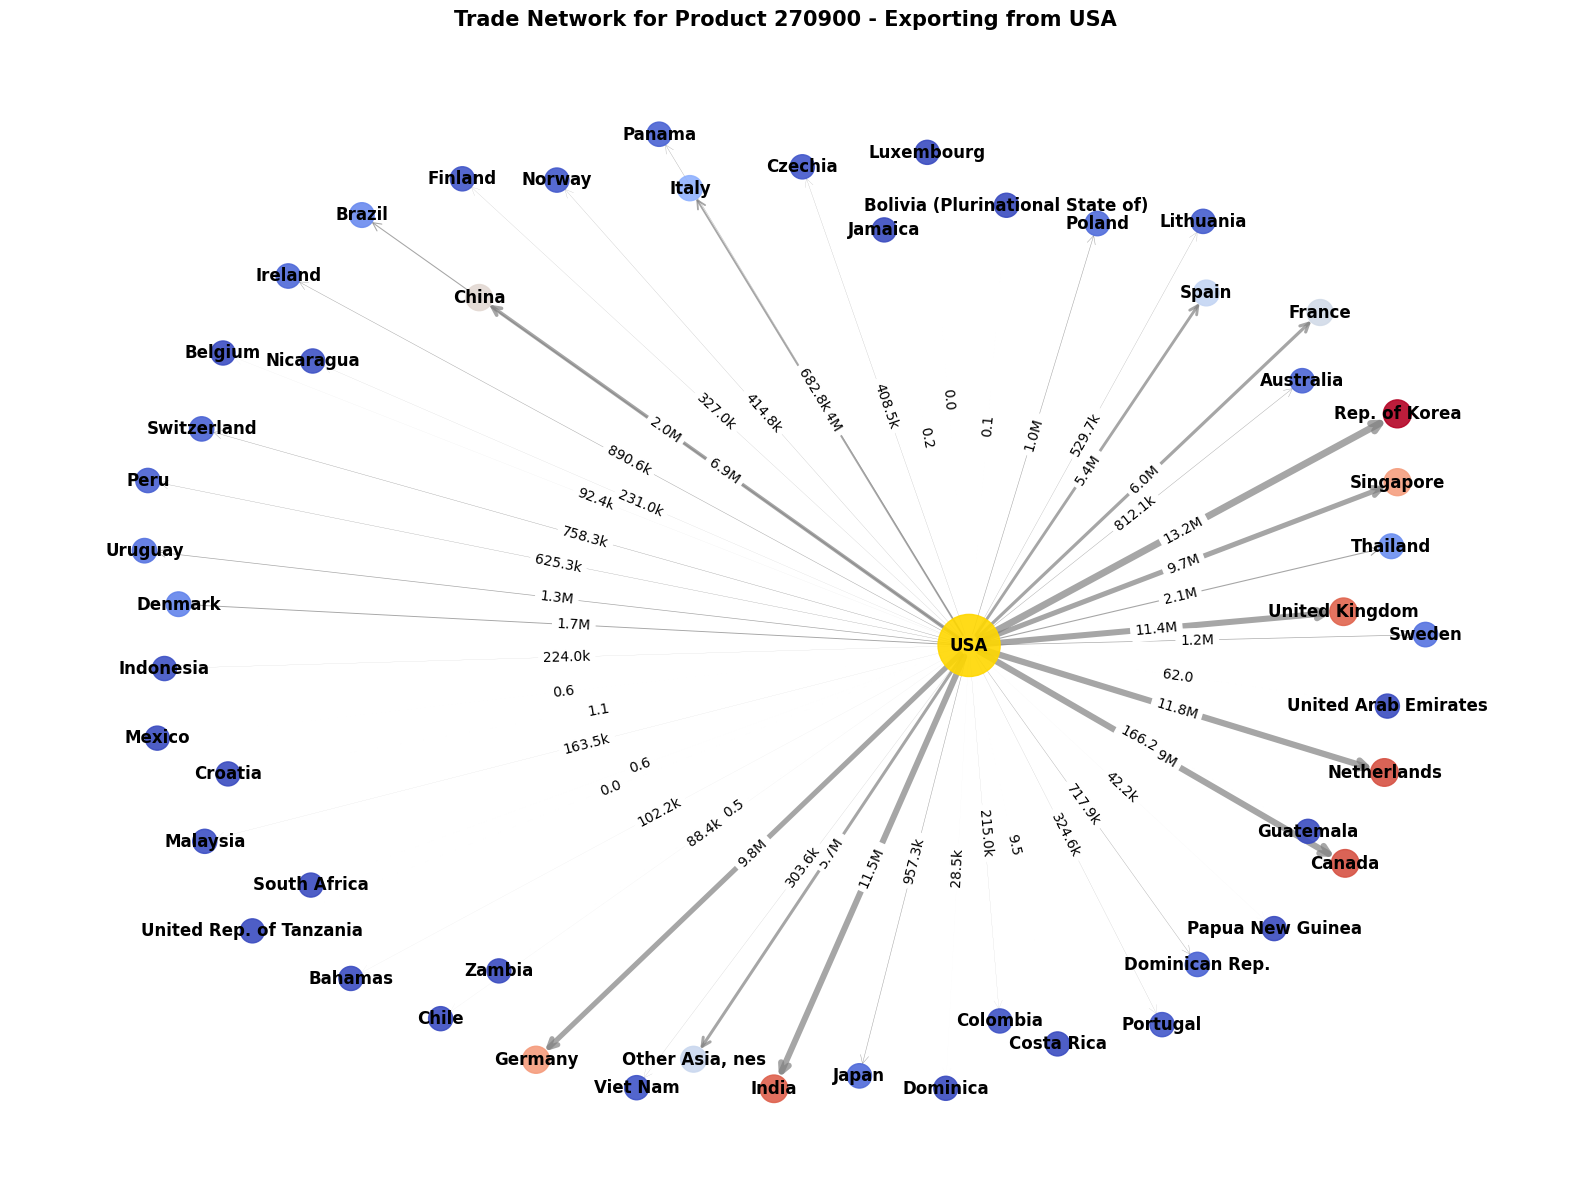

In [6]:
# 2022
df_2022 = pd.read_csv(r"dataset/BACI_HS22_Y2022_V202401b.csv")
df_2022 = merge_country_names(df_2022, country)

plot_trade_network(df_2022, product_code = 270900, country_name="USA")

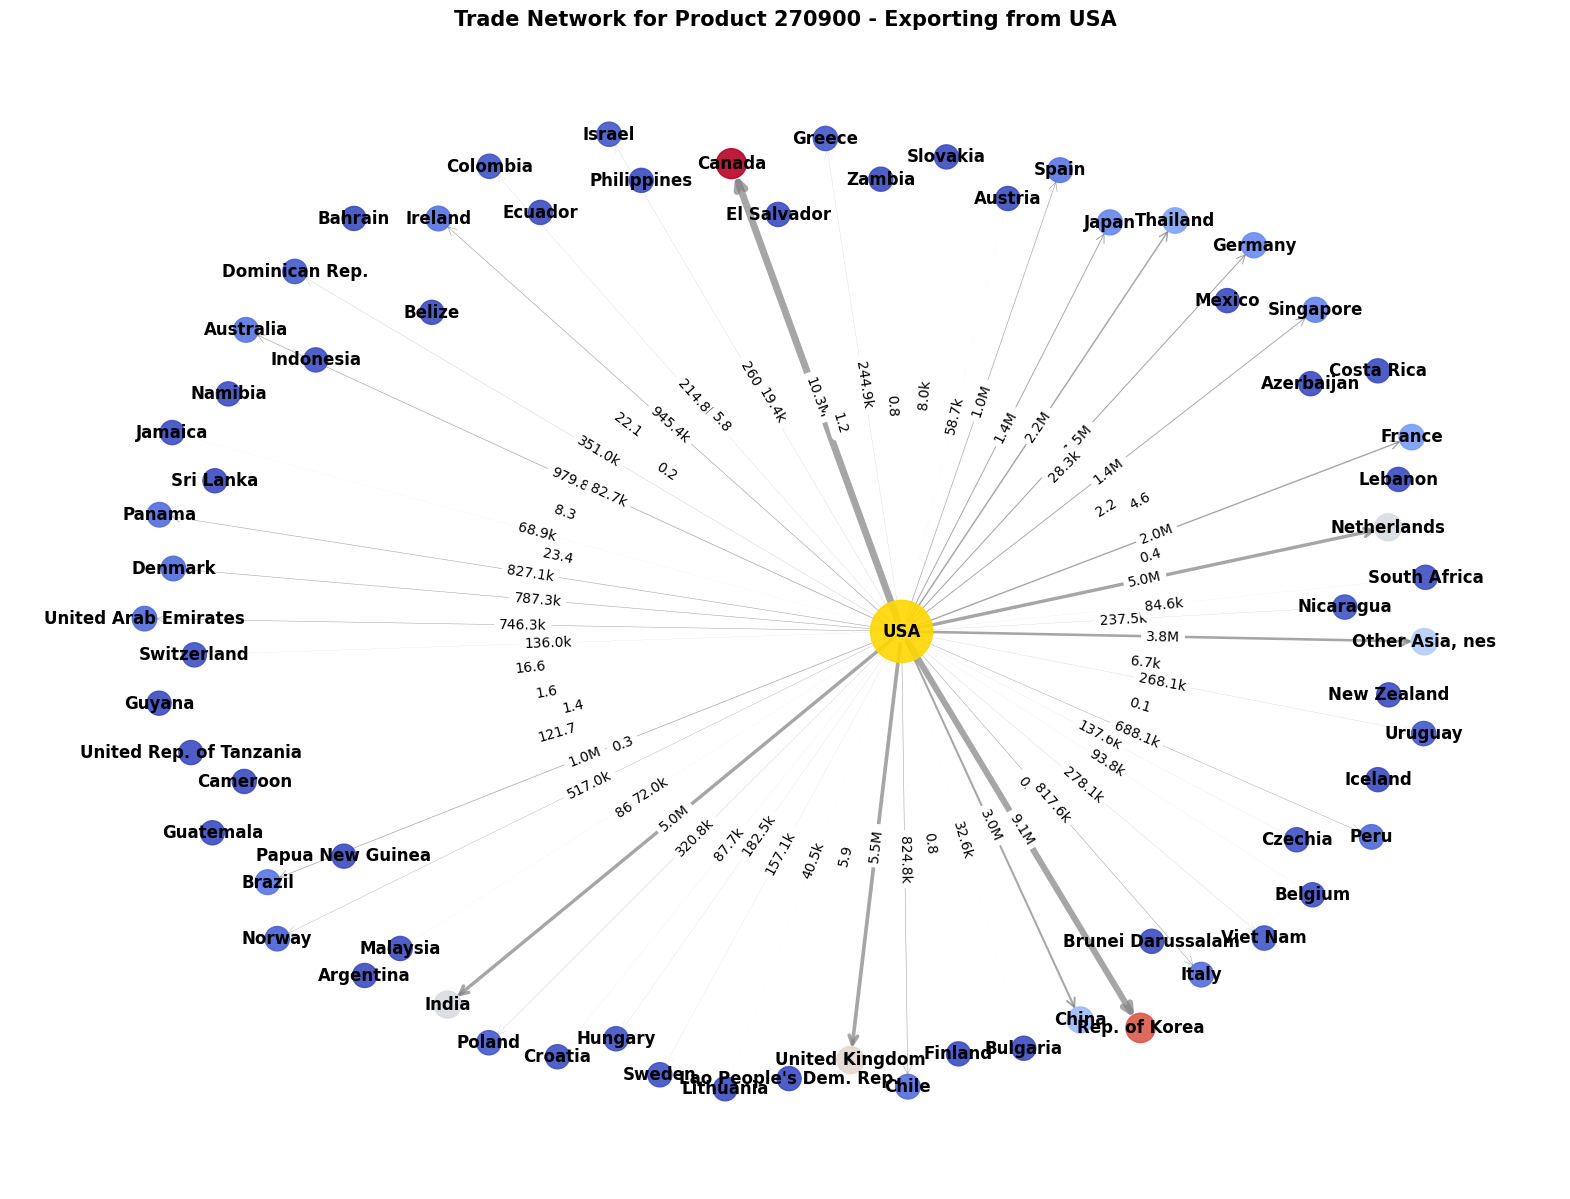

In [7]:
# 2019
df_2019 = pd.read_csv(r"dataset/BACI_HS17_Y2019_V202401b.csv")
df_2019 = merge_country_names(df_2019, country)

plot_trade_network(df_2019, product_code = 270900, country_name="USA")

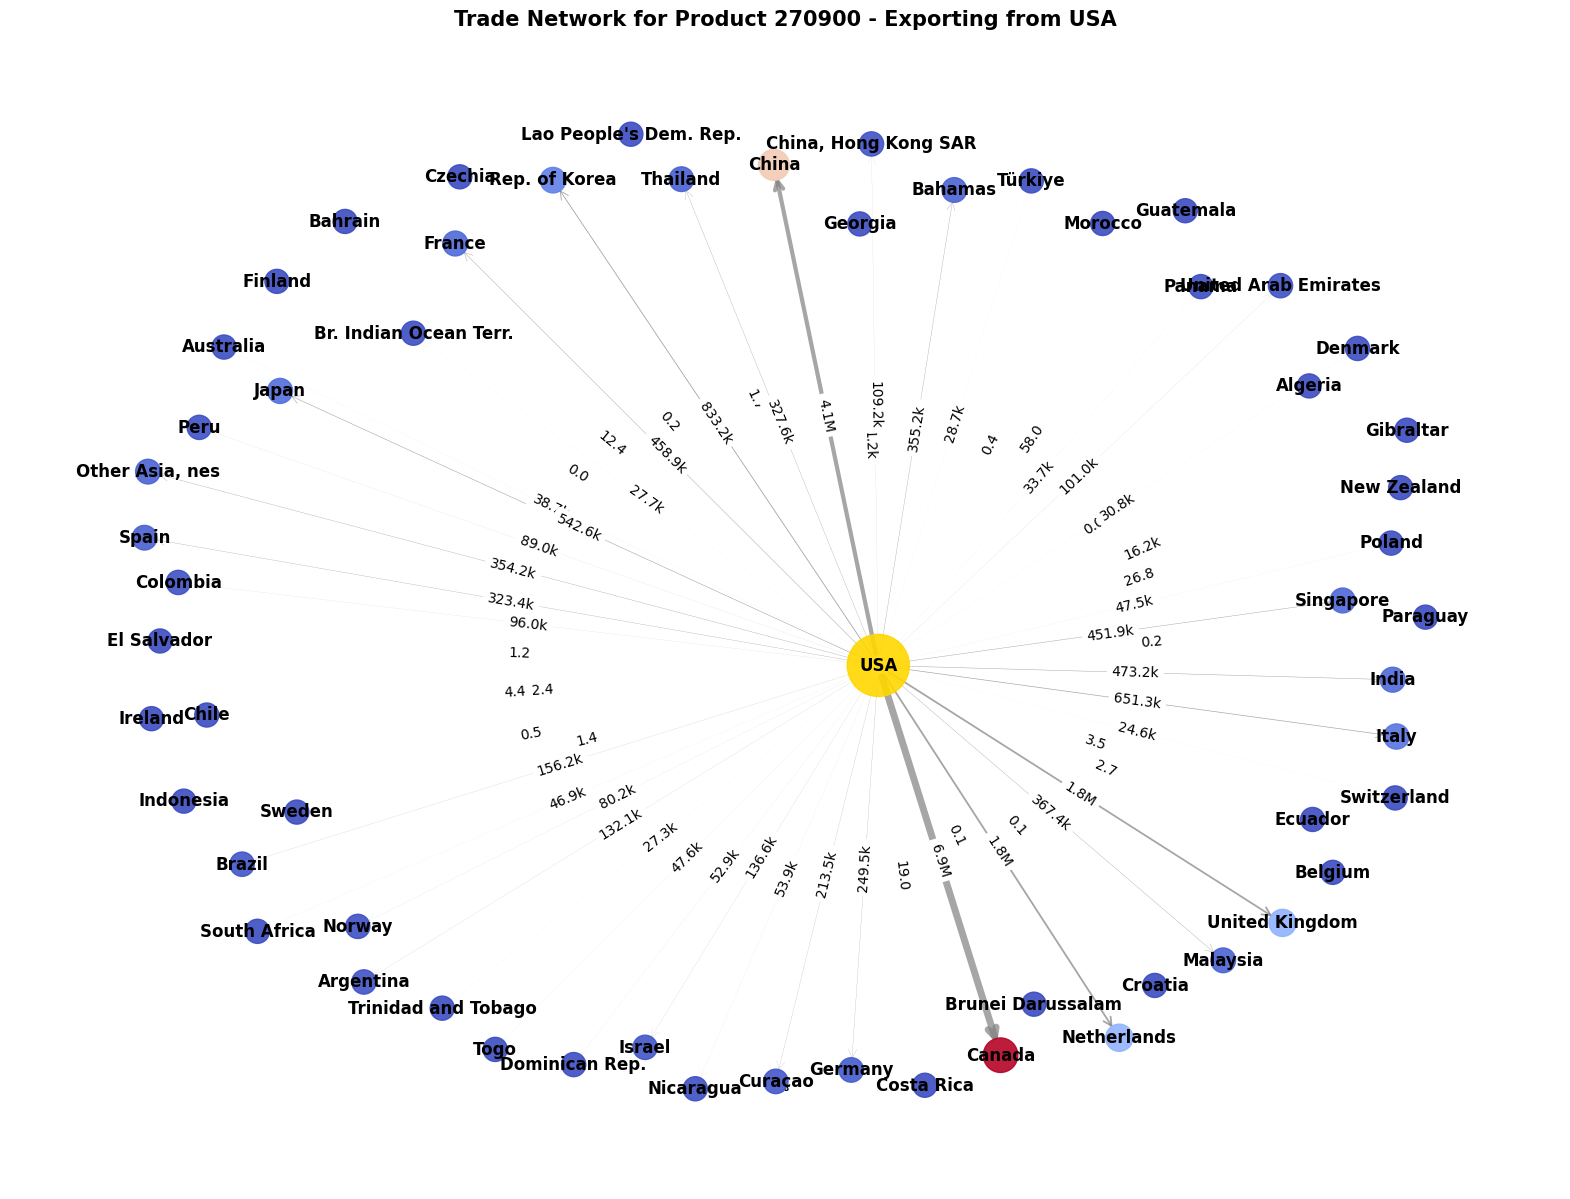

In [9]:
# 2017
df_2017 = pd.read_csv(r"dataset/BACI_HS17_Y2017_V202401b.csv")
df_2017 = merge_country_names(df_2017, country)

plot_trade_network(df_2017, product_code = 270900, country_name="USA")